In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
from keras.layers import Layer, ZeroPadding2D, Cropping2D
import tensorflow as tf
from tensorflow.keras import backend as K



Using TensorFlow backend.


In [0]:
# Set some parameters
im_width = 480
im_height = 360
border = 5

In [4]:
train_ti_ids = next(os.walk("/content/gdrive/My Drive/MonuSeg/Training/TissueImages/"))[2] # list of names all images in the given path
print("No. of images = ", len(train_ti_ids))

train_gt_ids = []

for i in range( len(train_ti_ids) ):
    #print(i)
    #print( train_ti_ids[i] )
    my_str = train_ti_ids[i]
    substr = ".png"
    inserttxt = "_bin_mask"
    idx = my_str.index(substr)
    my_str = my_str[:idx] + inserttxt + my_str[idx:]
    train_gt_ids.append(my_str)
    #print(my_str)

No. of images =  30


In [5]:
test_ti_ids = next(os.walk("/content/gdrive/My Drive/MonuSeg/Test/TissueImages/"))[2] # list of names all images in the given path
print("No. of images = ", len(test_ti_ids))

test_gt_ids = []

for i in range( len(test_ti_ids) ):
    #print(i)
    #print( test_ti_ids[i] )
    my_str = test_ti_ids[i]
    substr = ".tif"
    inserttxt = "_bin_mask"
    idx = my_str.index(substr)
    my_str = my_str[:idx] + inserttxt + ".png"
    test_gt_ids.append(my_str)
    #print(my_str)

No. of images =  14


In [0]:
def con_img_array(ids, base_path):
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    for i in (range(len(ids))):
        #print(ids[i])
        img = load_img( base_path + ids[i] , color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (360, 480, 1), mode = 'constant', preserve_range = True)
        X[i] = x_img/255.0
    #print("=========================================")
    return X


X_train = con_img_array(train_ti_ids, "/content/gdrive/My Drive/MonuSeg/Training/TissueImages/")
y_train = con_img_array(train_gt_ids, "/content/gdrive/My Drive/MonuSeg/Training/GroundTruth/")
X_test = con_img_array(test_ti_ids, "/content/gdrive/My Drive/MonuSeg/Test/TissueImages/")
y_test = con_img_array(test_gt_ids, "/content/gdrive/My Drive/MonuSeg/Test/GroundTruth/")

Text(0.5, 1.0, 'GroundTruth')

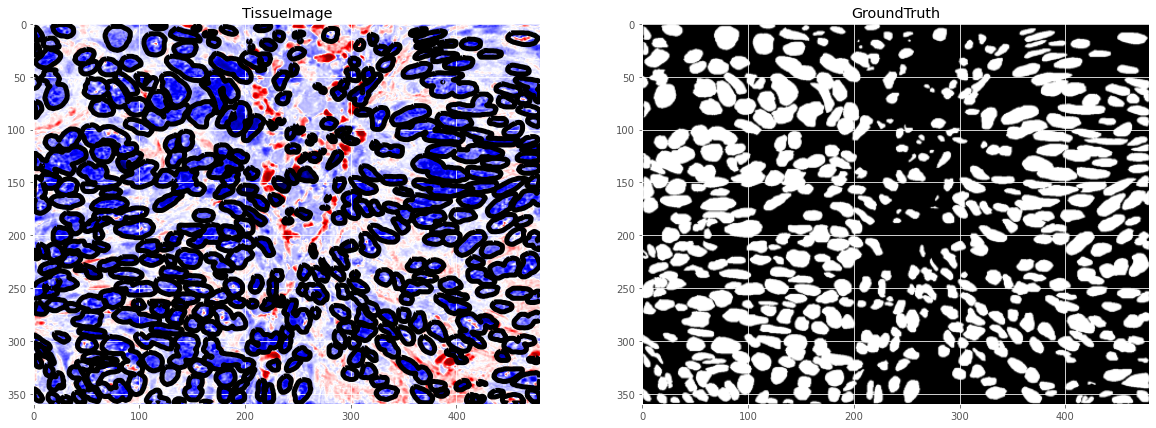

In [7]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('TissueImage')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GroundTruth')

In [0]:
class MaxPoolingWithIndices(keras.layers.Layer):
    def __init__(self, pool_size,strides,padding='SAME',**kwargs):
        super(MaxPoolingWithIndices, self).__init__(**kwargs)
        self.pool_size=pool_size
        self.strides=strides
        self.padding=padding
        return
    def call(self,x):
        pool_size=self.pool_size
        strides=self.strides
        if isinstance(pool_size,int):
            ps=[1,pool_size,pool_size,1]
        else:
            ps=[1,pool_size[0],pool_size[1],1]
        if isinstance(strides,int):
            st=[1,strides,strides,1]
        else:
            st=[1,strides[0],strides[1],1]
        output1,output2=tf.nn.max_pool_with_argmax(x,ps,st,self.padding)
        return [output1,output2]
    def compute_output_shape(self, input_shape):
        if isinstance(self.pool_size,int):
            output_shape=(input_shape[0],input_shape[1]//self.pool_size,input_shape[2]//self.pool_size,input_shape[3])
        else:
            output_shape=(input_shape[0],input_shape[1]//self.pool_size[0],input_shape[2]//self.pool_size[1],input_shape[3])
        return [output_shape,output_shape]


class UpSamplingWithIndices(Layer):
    def __init__(self, **kwargs):
        super(UpSamplingWithIndices, self).__init__(**kwargs)
        return
    def call(self,x):
        argmax=K.cast(K.flatten(x[1]),'int32')
        max_value=K.flatten(x[0])
        with tf.variable_scope(self.name):
            input_shape=K.shape(x[0])
            batch_size=input_shape[0]
            image_size=input_shape[1]*input_shape[2]*input_shape[3]
            output_shape=[input_shape[0],input_shape[1]*2,input_shape[2]*2,input_shape[3]]
            indices_0=K.flatten(tf.matmul(K.reshape(tf.range(batch_size),(batch_size,1)),K.ones((1,image_size),dtype='int32')))
            indices_1=argmax%(image_size*4)//(output_shape[2]*output_shape[3])
            indices_2=argmax%(output_shape[2]*output_shape[3])//output_shape[3]
            indices_3=argmax%output_shape[3]
            indices=tf.stack([indices_0,indices_1,indices_2,indices_3])
            output=tf.scatter_nd(K.transpose(indices),max_value,output_shape)
            return output
    def compute_output_shape(self, input_shape):
        return input_shape[0][0],input_shape[0][1]*2,input_shape[0][2]*2,input_shape[0][3]

def CompositeConv(inputs,num_layers,num_features):
    output=inputs
    if isinstance(num_features,int):
        for i in range(num_layers):
            output=Conv2D(num_features,(7,7),padding='same')(output)
            output=BatchNormalization(axis=3)(output)
            output=Activation('relu')(output)
        return output
    for i in range(num_layers):
        output=Conv2D(num_features[i],(7,7),padding='same')(output)
        output=BatchNormalization(axis=3)(output)
        output=Activation('relu')(output)
    return output

In [9]:
inputs=Input(shape=(360,480,1))

x = ZeroPadding2D(((12,12),(16,16)))(inputs)

x=CompositeConv(x,2,64)
x,argmax1=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,2,64)
x,argmax2=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,3,64)
x,argmax3=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,3,64)
x,argmax4=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,3,64)
x,argmax5=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=UpSamplingWithIndices()([x,argmax5])
x=CompositeConv(x,3,64)

x=UpSamplingWithIndices()([x,argmax4])
x=CompositeConv(x,3,64)

x=UpSamplingWithIndices()([x,argmax3])
x=CompositeConv(x,3,64)

x=UpSamplingWithIndices()([x,argmax2])
x=CompositeConv(x,2,64)

x=UpSamplingWithIndices()([x,argmax1])
x=CompositeConv(x,2,[64,1])

x=Activation('sigmoid')(x)

y=Cropping2D(((12,12),(16,16)))(x)


model=Model(inputs=inputs,outputs=y)

In [10]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


binary_crossentropy = "binary_crossentropy"


input_img = Input((im_height, im_width, 1), name='img')
# model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss=[binary_crossentropy], metrics=["accuracy", f1_m, precision_m, recall_m, dice_coef])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', save_best_only=True, save_weights_only=True, verbose=1)
]

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 360, 480, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 384, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 384, 512, 64) 3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 384, 512, 64) 256         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [13]:
results = model.fit(X_train, y_train, batch_size=32, 
                    epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), verbose = 1)



Train on 30 samples, validate on 14 samples
Epoch 1/50
30/30 [==============================] - 140s 5s/step - loss: 0.8493 - acc: 0.3207 - f1_m: 0.3074 - precision_m: 0.2340 - recall_m: 0.4478 - dice_coef: 0.8030 - val_loss: 0.6932 - val_acc: 0.6388 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_dice_coef: 0.8275

Epoch 00001: val_loss improved from inf to 0.69316, saving model to model-tgs-salt.h5
Epoch 2/50
30/30 [==============================] - 126s 4s/step - loss: 0.7653 - acc: 0.1444 - f1_m: 0.3137 - precision_m: 0.2060 - recall_m: 0.6578 - dice_coef: 0.8138 - val_loss: 0.6931 - val_acc: 0.6388 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_dice_coef: 0.8275

Epoch 00002: val_loss improved from 0.69316 to 0.69315, saving model to model-tgs-salt.h5
Epoch 3/50
30/30 [==============================] - 126s 4s/step - loss: 0.7440 - acc: 0.1341 - f1_m: 0.3255 - precision_m: 0.2097 - recall_m: 0.7274 - di

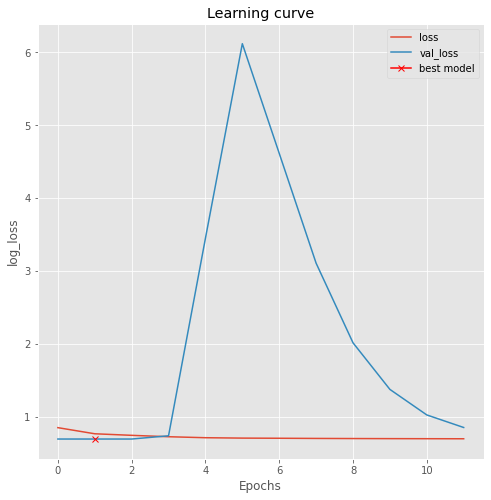

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.savefig("unet_loss.png")

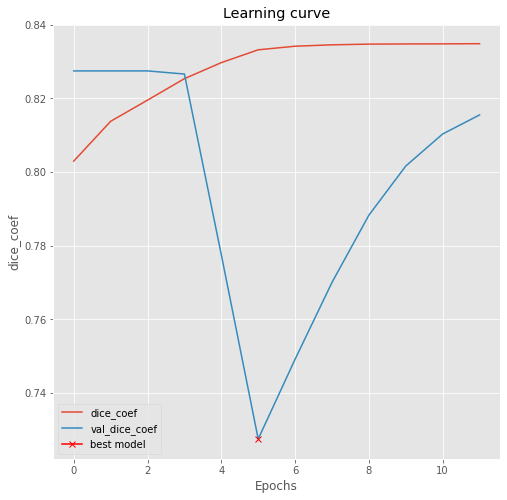

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(results.history["val_dice_coef"]), np.min(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();
plt.savefig("unet_dice_coef.png")

In [0]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [25]:
# Evaluate on validation set (this must be equals to the best log_loss)
loss, accuracy, f1_score, precision, recall , dice_score = model.evaluate(X_test, y_test, verbose=1)

print("unet_loss:", loss)
print("unet_Accuracy:", accuracy)
print("unet_f1_score:", f1_score)
print("unet_dice_score:", dice_score)


14/14 [==============================] - 8s 596ms/step
unet_loss: 0.6931458711624146
unet_Accuracy: 0.6388099193572998
unet_f1_score: 0.0
unet_dice_score: 0.8274781703948975


In [18]:
# Predict on train and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

14/14 [==============================] - 8s 597ms/step


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Tissue Images')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Ground Truth Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Ground Truth Predicted binary');

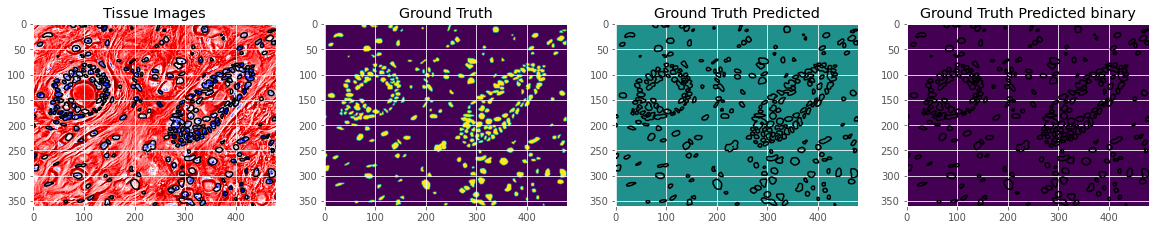

In [21]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

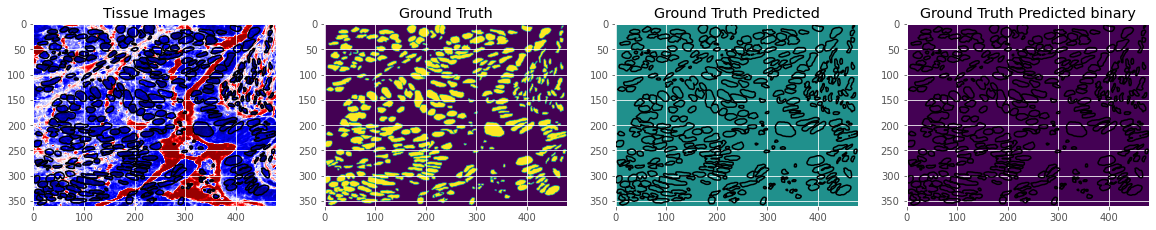

In [22]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

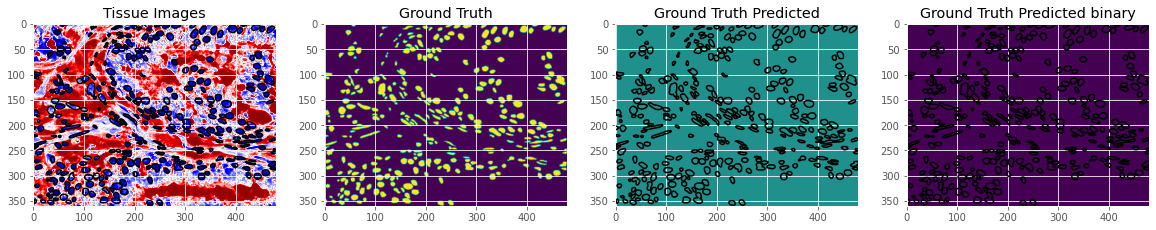

In [23]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=10)

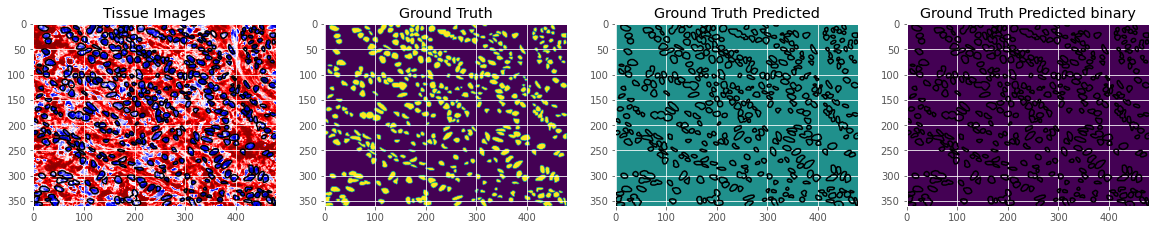

In [24]:
plot_sample(X_test, y_test, preds_test, preds_test_t)